In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

In [2]:
dt = 0.01
TR = 1
down_sample = int(TR/dt)
sigma = 1

In [10]:
def h(x):
    return np.tanh(x)

def NextTR(W, X_init, noise):
    X_res = X_init.copy()
    for i in range(down_sample):
        X_res = X_res + (-X_res + np.dot(W.T, h(X_res))) * dt + noise[i]
    return X_res

def RNN(W, X_init, length, pert_strength=1.0, pert_step=200):
    np.random.seed(0)
    n = len(X_init)
    X = [X_init]
    real_EC = np.zeros((n, n))
    pert_count = 0

    for i in range(1, length):
        noise = (sigma * np.sqrt(dt)) * np.random.normal(0, 1, (down_sample, n))
        X.append(NextTR(W, X[-1], noise))

        if i % pert_step == 0:
            pert_count += 1
            for j in range(n):
                perted_init = X[-2].copy()
                perted_init[j] += pert_strength
                real_EC[j] += NextTR(W, perted_init, noise) - X[-1]

    real_EC /= pert_count
    np.fill_diagonal(real_EC, 0)

    return np.array(X), real_EC

In [11]:
node_n = 20
data_length = 8000
random_seed = 0

np.random.seed(random_seed)
SC = np.random.normal(0, 1/np.sqrt(node_n), (node_n, node_n))
np.fill_diagonal(SC, 0)
X_init = np.random.normal(0, 1, (node_n,))

signal, real_EC = RNN(SC, X_init, data_length)

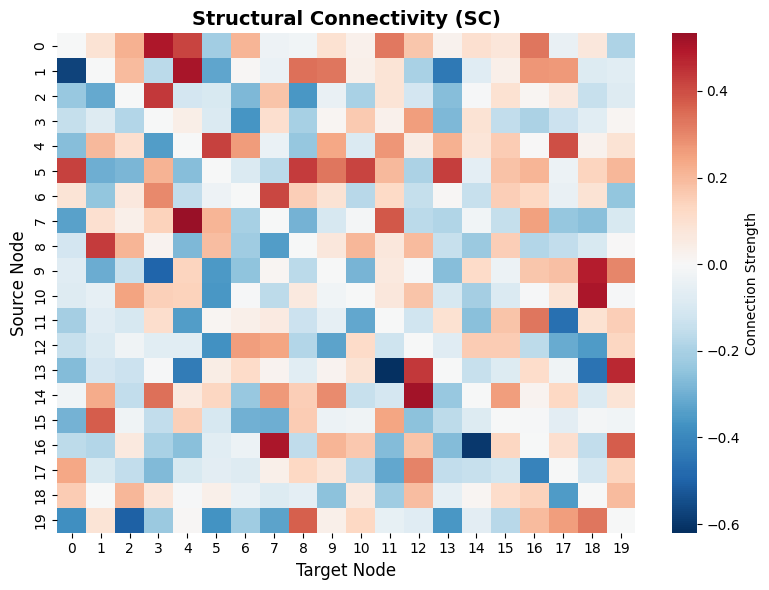

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(SC, cmap='RdBu_r', center=0, cbar_kws={'label': 'Connection Strength'})
plt.title('Structural Connectivity (SC)', fontsize=14, fontweight='bold')
plt.xlabel('Target Node', fontsize=12)
plt.ylabel('Source Node', fontsize=12)
plt.tight_layout()
plt.show()

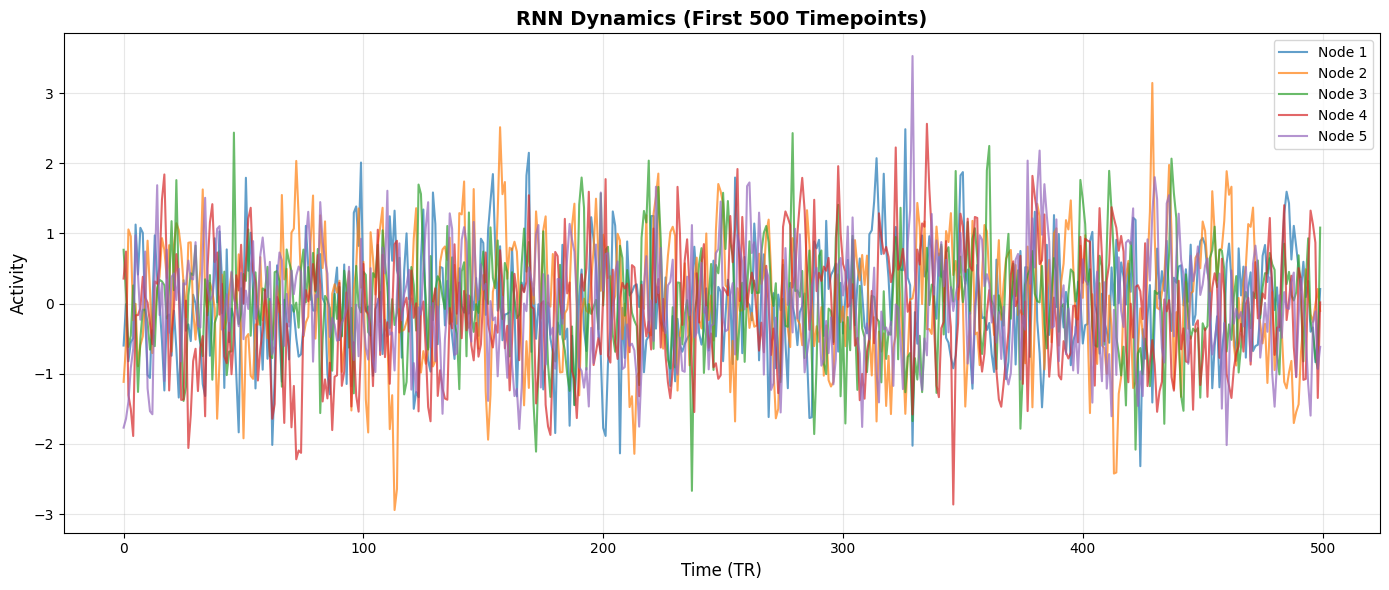

In [13]:
plt.figure(figsize=(14, 6))
for i in range(min(5, node_n)):
    plt.plot(signal[:500, i], label=f'Node {i+1}', alpha=0.7)
plt.xlabel('Time (TR)', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.title('RNN Dynamics (First 500 Timepoints)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

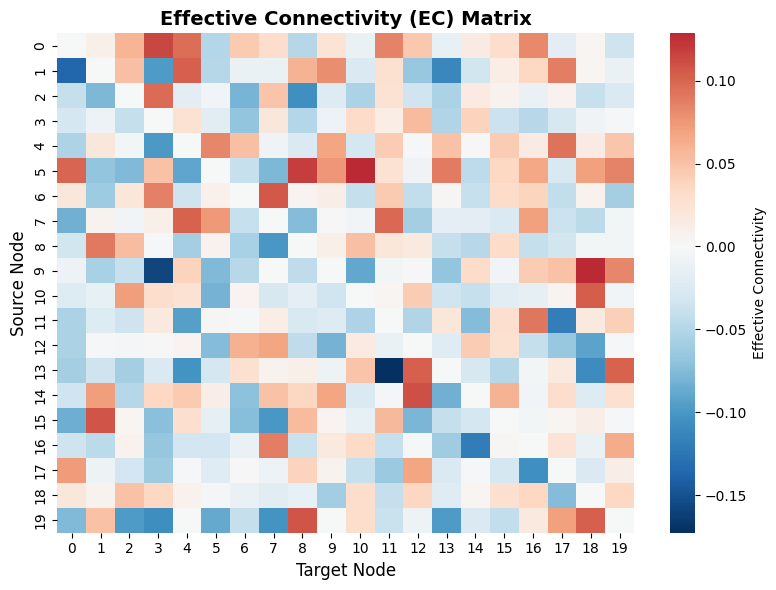

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(real_EC, cmap='RdBu_r', center=0, cbar_kws={'label': 'Effective Connectivity'})
plt.title('Effective Connectivity (EC) Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Target Node', fontsize=12)
plt.ylabel('Source Node', fontsize=12)
plt.tight_layout()
plt.show()

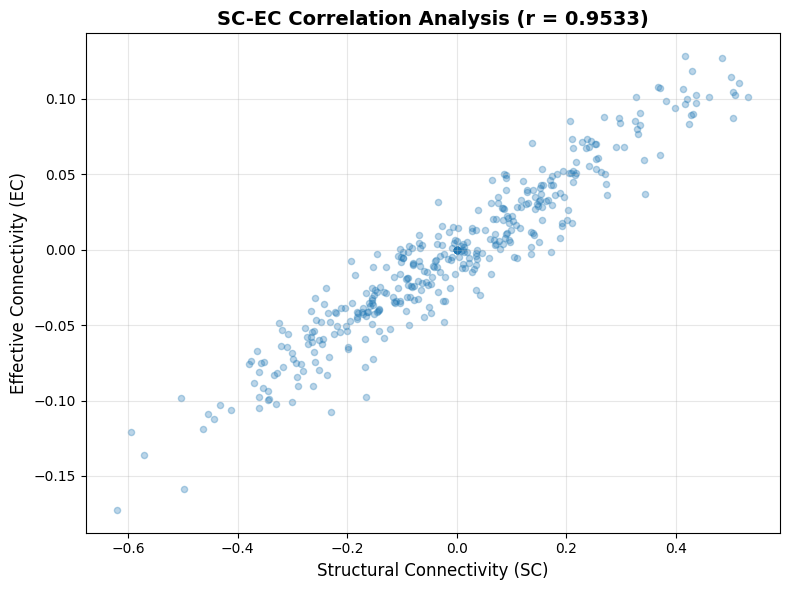

Pearson correlation coefficient: r = 0.9533
p-value: 5.13e-209


In [15]:
SC_flat = SC.flatten()
EC_flat = real_EC.flatten()
r, p = pearsonr(SC_flat, EC_flat)

plt.figure(figsize=(8, 6))
plt.scatter(SC_flat, EC_flat, alpha=0.3, s=20)
plt.xlabel('Structural Connectivity (SC)', fontsize=12)
plt.ylabel('Effective Connectivity (EC)', fontsize=12)
plt.title(f'SC-EC Correlation Analysis (r = {r:.4f})', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Pearson correlation coefficient: r = {r:.4f}')
print(f'p-value: {p:.2e}')

In [16]:
EC_no_diag = real_EC.copy()
np.fill_diagonal(EC_no_diag, 0)

exc = EC_no_diag[EC_no_diag > 0]
inh = EC_no_diag[EC_no_diag < 0]

threshold = np.percentile(np.abs(EC_no_diag[EC_no_diag != 0]), 80)
strong = (np.abs(EC_no_diag) > threshold).sum()
total = node_n * (node_n - 1)
sparsity = 1 - (strong / total)

print('Excitatory/Inhibitory Analysis:')
print(f'  Excitatory connections: {len(exc)} ({len(exc)/(len(exc)+len(inh))*100:.1f}%)')
print(f'  Inhibitory connections: {len(inh)} ({len(inh)/(len(exc)+len(inh))*100:.1f}%)')
print(f'  Maximum excitatory strength: {exc.max():.4f}')
print(f'  Maximum inhibitory strength: {abs(inh.min()):.4f}')
print(f'  Excitatory/Inhibitory ratio: {abs(inh.min())/exc.max():.4f}')

print('\nDistribution Statistics:')
print(f'  Mean: {EC_no_diag[EC_no_diag != 0].mean():.6f}')
print(f'  Standard deviation: {EC_no_diag[EC_no_diag != 0].std():.6f}')
print(f'  Minimum: {EC_no_diag.min():.4f}')
print(f'  Maximum: {EC_no_diag.max():.4f}')

print('\nSparsity Analysis:')
print(f'  Strong connections (top 20%): {strong}')
print(f'  Total connections: {total}')
print(f'  Network sparsity: {sparsity:.4f}')

Excitatory/Inhibitory Analysis:
  Excitatory connections: 170 (44.7%)
  Inhibitory connections: 210 (55.3%)
  Maximum excitatory strength: 0.1285
  Maximum inhibitory strength: 0.1726
  Excitatory/Inhibitory ratio: 1.3432

Distribution Statistics:
  Mean: -0.004344
  Standard deviation: 0.053514
  Minimum: -0.1726
  Maximum: 0.1285

Sparsity Analysis:
  Strong connections (top 20%): 76
  Total connections: 380
  Network sparsity: 0.8000


In [19]:
output_dir = '/content/sample_data'
filename_base = f'{output_dir}/RNN_{node_n}nodes_{data_length}steps_seed{random_seed}'

np.savetxt(f'{filename_base}_SC.txt', SC, fmt='%.6f')
np.savetxt(f'{filename_base}_dynamics.txt', signal, fmt='%.6f')
np.savetxt(f'{filename_base}_real_EC.txt', real_EC, fmt='%.6f')

sc_size = os.path.getsize(f'{filename_base}_SC.txt') / 1024
dyn_size = os.path.getsize(f'{filename_base}_dynamics.txt') / 1024
ec_size = os.path.getsize(f'{filename_base}_real_EC.txt') / 1024

print('Files exported successfully:')
print(f'  Structural connectivity: {sc_size:.1f} KB')
print(f'  Network dynamics: {dyn_size:.1f} KB')
print(f'  Effective connectivity: {ec_size:.1f} KB')

Files exported successfully:
  Structural connectivity: 3.7 KB
  Network dynamics: 1484.2 KB
  Effective connectivity: 3.7 KB
